# PC5228 Assignment, Extension

Previously, we have used the IBMQ platform to run a Mach-Zehnder interferometer-like experiment using Quantum Computers. Now, we modify the interferometer by adding an ancilla and a controlled operation on the original qubit and the ancilla. Naturally, this will entangle the qubit and the ancilla. The rest of the interferometer proceeds as usual. What we will have is a reduction in the visibility of the interference based on the degree of the entanglement.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.tools.jupyter import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Similarly to the previous interferometer procedure, we start with a simulator part

In [2]:
# Get the simulator
simulator = Aer.get_backend('qasm_simulator')

# Parameters
phase_steps = 50
rot_steps = 10
phases = np.linspace(0, 2*np.pi, num=phase_steps)
rots = np.linspace(0, np.pi, num=rot_steps)

# Variables
data = np.ndarray((rot_steps, phase_steps, 2))

# Construct the Mach-Zehnder interferometer
for i in range(rot_steps):
    rot = rots[i]
    for j in range(phase_steps):
        phase = phases[j]
        mzint = QuantumCircuit(2,1)
        mzint.h(0)
        crx = RXGate(rot).control()
        mzint.append(crx, [0,1])
        mzint.p(phase, 0)
        mzint.h(0)
        mzint.measure(0, 0)
        
        # Run it on the simulator
        job = execute(mzint, simulator, shots=2048)
        result = job.result()

        counts = result.get_counts(mzint)

        try:
            data[i, j, 0] = counts['0']
        except KeyError:
            data[i, j, 0] = 0
        try:
            data[i, j, 1] = counts['1']
        except KeyError:
            data[i, j, 1] = 0

After generating the simulated data, let us plot the result.

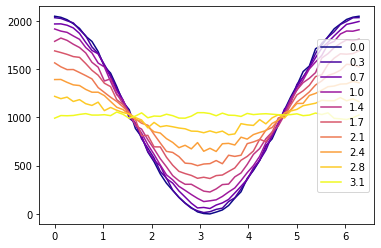

In [3]:
cmap = matplotlib.cm.get_cmap('plasma')

for i in range(rot_steps):
    rot = rots[i]
    rgba = cmap(rot/np.pi)
    plt.plot(phases, data[i,:,0], color=rgba, label=round(rot,1))

plt.legend(loc='right')
plt.show()

As can be seen, the interference dies down as the phase $\phi$ is increased. Let us now run it on a Quantum Computer.

In [4]:
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
machines = provider.backends(simulator=False, operational=True, filters=lambda x: x.configuration().n_qubits >= 2)
backend = least_busy(machines)
backend

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
# Parameters
phase_steps = 50
rot_steps = 10
phases = np.linspace(0, 2*np.pi, num=phase_steps)
rots = np.linspace(0, np.pi, num=rot_steps)

# Variables
data = np.ndarray((rot_steps, phase_steps, 2))

# Construct the Mach-Zehnder interferometer
for i in range(rot_steps):
    rot = rots[i]
    for j in range(phase_steps):
        phase = phases[j]
        mzint = QuantumCircuit(2,1)
        mzint.h(0)
        crx = RXGate(rot).control()
        mzint.append(crx, [0,1])
        mzint.p(phase, 0)
        mzint.h(0)
        mzint.measure(0, 0)
        
        # Run the code to a Quantum Computer
        transpiled = transpile(mzint, backend=backend)
        job = backend.run(transpiled, shots=2048)
        result = job.result()

        counts = result.get_counts(mzint)

        try:
            data[i, j, 0] = counts['0']
        except KeyError:
            data[i, j, 0] = 0
        try:
            data[i, j, 1] = counts['1']
        except KeyError:
            data[i, j, 1] = 0

# Save the results
for i in range(rot_steps):
    np.savetxt('data_'+str(i)+'.txt', data[i,:,:])

Let us plot the results.

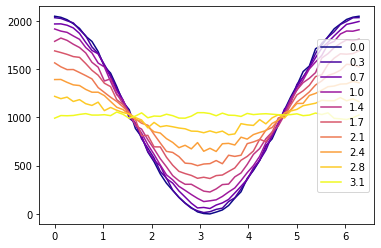

In [4]:
cmap = matplotlib.cm.get_cmap('plasma')

for i in range(rot_steps):
    rot = rots[i]
    rgba = cmap(rot/np.pi)
    plt.plot(phases, data[i,:,0], color=rgba, label=round(rot,1))

plt.legend(loc='right')
plt.show()